In [1]:
###IMPORTS#############################################
import os, sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error
from ahrs.filters import Complementary
from ahrs.common import quaternion as quat
#######################################################

In [2]:
#bot_state_dir = os.getcwd() + "\\mavic_state.csv"
#bot_state_dir = os.getcwd() + "\\mavic_state2.csv"
#bot_state_dir = os.getcwd() + "\\mavic_state3.csv"
bot_state_dir = os.getcwd() + "\\mavic_state4.csv"

print(bot_state_dir)
cols = ['x_pos', 'y_pos', 'z_pos', 
        'roll_rot', 'pitch_rot', 'yaw_rot',
        'x_vel', 'y_vel', 'alt_vel',
        'x_acc', 'y_acc', 'alt_acc',
        'roll_vel', 'pitch_vel', 'yaw_vel',
        'timestep',
        'phi_dot', 'theta_dot', 'psi_dot',
        'xvel_local', 'yvel_local', 'zvel_local',
        'xdot_global', 'ydot_global', 'zdot_global',
        'xpos_global', 'ypos_global', 'zpos_global',
        'roll_ang', 'pitch_ang', 'yaw_ang'
       ]






bot_stateDF = pd.read_csv(bot_state_dir, names=cols)
print(bot_stateDF.shape)
print(bot_stateDF)

C:\Users\ericx\OneDrive\Desktop\mine\grad_school\MARS_Lab_Swarm\Gazebo_dragonFly\webots_tutorial\hovering_test_project\python_utilities\mavic_state4.csv
(13494, 31)
          x_pos     y_pos     z_pos  roll_rot  pitch_rot   yaw_rot     x_vel  \
0      0.000045 -0.000002  0.147444 -0.000034   0.000244 -0.000050  0.002818   
1      0.000082 -0.000003  0.142386 -0.000080   0.000505 -0.000093  0.002287   
2      0.000112 -0.000003  0.134838 -0.000128   0.000758 -0.000131  0.001838   
3      0.000135 -0.000004  0.124810 -0.000171   0.000993 -0.000164  0.001469   
4      0.000154 -0.000004  0.112313 -0.000207   0.001202 -0.000195  0.001173   
...         ...       ...       ...       ...        ...       ...       ...   
13489  0.524763 -0.055479  2.714514 -0.263064  -0.016965 -0.253267  1.526947   
13490  0.549530 -0.062912  2.701608 -0.521796  -0.089645 -0.273004  1.550733   
13491  0.574783 -0.069066  2.685998 -0.804658  -0.170219 -0.281734  1.584604   
13492  0.600708 -0.074428  2.667182

In [3]:
#PID_dir = os.getcwd() + "\\PID_and_inputs.csv"
PID_dir = os.getcwd() + "\\PID_and_inputs2.csv"
#PID_dir = os.getcwd() + "\\PID_and_inputs3.csv"
#PID_dir = os.getcwd() + "\\PID_and_inputs4.csv"

print(PID_dir)
cols = ['xposPD', 'yposPD',
        'rollPID', 'pitchPID', 'yawPID', 'throttlePID',
        'rollDotPID', 'pitchDotPID', 'yawDotPID',
        'roll_input', 'pitch_input', 
        'yaw_input', 'vertical_input',
        'diff_altitude', 'clampd_diff_altitude',
       'front_left_motor', 'front_right_motor',
        'rear_left_motor', 'rear_right_motor']



PIDinputsDF = pd.read_csv(PID_dir, names=cols)
print(PIDinputsDF.shape)
print(PIDinputsDF)

C:\Users\ericx\OneDrive\Desktop\mine\grad_school\MARS_Lab_Swarm\Gazebo_dragonFly\webots_tutorial\hovering_test_project\python_utilities\PID_and_inputs2.csv
(3751, 19)
        xposPD    yposPD   rollPID  pitchPID    yawPID  throttlePID  \
0     0.000145  0.000102  0.000017 -0.000057  0.000079     3.894202   
1     0.000145  0.000102  0.000017 -0.000057  0.000079     3.894202   
2     0.001655  0.000137  0.000364 -0.006357  0.002382     4.252673   
3     0.001655  0.000137  0.000364 -0.006357  0.002382     4.252673   
4     0.002046  0.000148  0.000601 -0.010611  0.003656     5.101362   
...        ...       ...       ...       ...       ...          ...   
3746 -0.015470  0.063657 -0.000105  0.009612  0.000897     1.111000   
3747 -0.015470  0.063657 -0.000105  0.009612  0.000897     1.111000   
3748 -0.015470  0.063657 -0.000105  0.009612  0.000897     1.111000   
3749 -0.015563  0.063681 -0.000107  0.009616  0.001022     1.111125   
3750 -0.015563  0.063681 -0.000107  0.009616  0.0010

In [4]:
#used as S-matrix for euler_dots = inverse(S-matrix)*gyro-measured velocity
def getEulerKinematicEqs(roll_ang, pitch_ang):
    euler_kin_matrix = np.array([[1, (np.sin(roll_ang)*np.tan(pitch_ang)), (np.cos(roll_ang)*np.tan(pitch_ang))],
                                 [0, np.cos(roll_ang), -np.sin(roll_ang)],
                                 [0, ((float(1)/np.cos(pitch_ang))*np.sin(roll_ang)), ((float(1)/np.cos(pitch_ang))*np.cos(roll_ang))]])
    #returns [phi_dot, theta_dot, psi_dot]
    return euler_kin_matrix

In [5]:
#used as RotMatrix for expressing trans-vel(global) = RotMatrix(l2g)*trans-vel(local)
def getLocalToGlobalRotation(roll_ang, pitch_ang, yaw_ang):
    
    rot_matrix = np.array([[np.cos(roll_ang)*np.cos(yaw_ang),
                            (np.sin(roll_ang)*np.sin(pitch_ang)*np.cos(yaw_ang))-(np.cos(roll_ang)*np.sin(yaw_ang)),
                            (np.cos(roll_ang)*np.sin(pitch_ang)*np.cos(yaw_ang))+(np.sin(roll_ang)*np.sin(yaw_ang))],
                          [np.sin(yaw_ang)*np.cos(pitch_ang),
                           (np.sin(roll_ang)*np.sin(pitch_ang)*np.sin(yaw_ang))+(np.cos(roll_ang)*np.cos(yaw_ang)),
                           (np.cos(roll_ang)*np.sin(pitch_ang)*np.sin(yaw_ang))-(np.sin(roll_ang)*np.cos(yaw_ang))],
                          [-np.sin(pitch_ang),
                           np.sin(roll_ang)*np.cos(pitch_ang),
                           np.cos(roll_ang)*np.cos(pitch_ang)]])
    #RotMatrix
    return rot_matrix

length of roll vel: 13494
length of timestep: 13494
[ 1.79807924e-04  1.43751523e-04  1.13912840e-04 ... -1.78062245e+01
 -1.92040446e+01 -2.04657517e+01]
(2.4, -0.0516256389084686)
(2.416, -0.0897880382061613)
(2.432, -0.1102802926594038)
(2.448, -0.0603563129893498)
(2.464, -0.0543285759715048)
(2.512, 0.0749297936969591)
(2.528, 0.1513844242062813)
(2.544, 0.1870820093143088)
(2.56, 0.1826302091646646)
(2.576, 0.1411722434211062)
(2.592, 0.0674270236504868)
(2.624, -0.1049248810243069)
(2.64, -0.1262732528744242)
(2.656, -0.1079701476990862)
(2.672, -0.0674472704131964)
(2.72, 0.0701823118636251)
(2.736, 0.1063408776103294)
(2.752, 0.1178030409164719)
(2.768, 0.0663680088008645)
(2.8000000000000003, -0.0641112538069935)
(2.816, -0.0821426394915247)
(2.832, -0.0733722834465839)
(2.928, 0.0529292755970105)
(2.944, 0.058620467223302)
(2.96, 0.0551350737480065)
(3.008, -0.0535995844378376)
(3.024, -0.0590439643036374)
(42.864, -0.074343937340315)
(42.88, -0.2016538051632571)
(42.896, -0

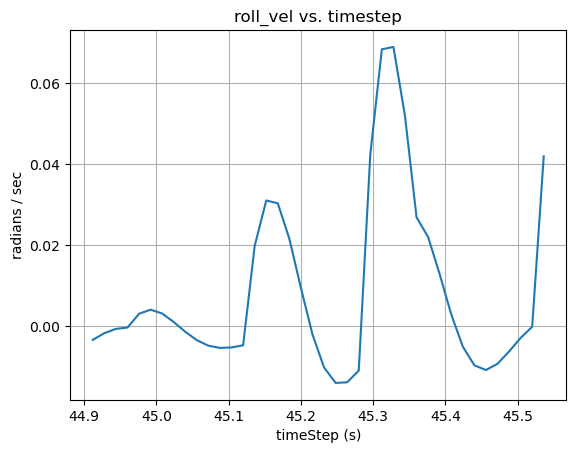

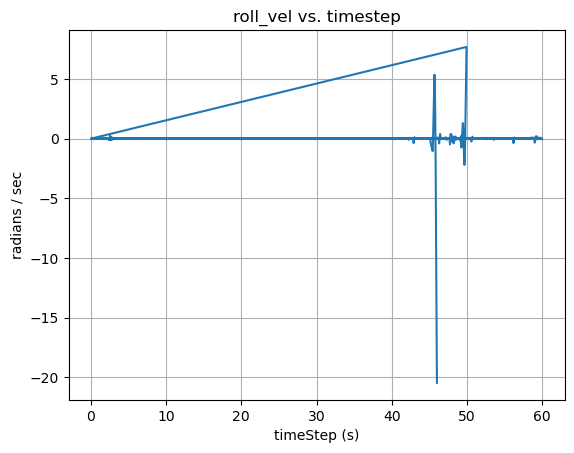

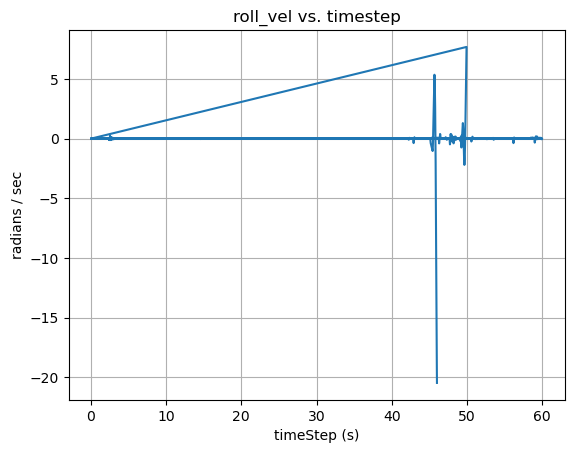

In [6]:
#plot roll velocity from gyro vs. timestep
roll_vel = np.array(bot_stateDF["roll_vel"])
timestep = np.array(bot_stateDF["timestep"])
print("length of roll vel: {}".format(len(roll_vel)))
print("length of timestep: {}".format(len(timestep)))
print(roll_vel[10:])

peakvals = []
for i, deg in enumerate(roll_vel):
    if deg > 0.05 or deg < -0.05:
        peakvals.append((timestep[i], deg))
for peak in peakvals:
    print(peak)



print(np.mean(roll_vel[2805:2845]))

plt.plot(timestep[2805:2845], roll_vel[2805:2845])
plt.title("roll_vel vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("radians / sec")
plt.grid()
plt.show()



plt.plot(timestep[100:], roll_vel[100:])
#lt.plot(timestep, roll_vel)
plt.title("roll_vel vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("radians / sec")
plt.grid()
plt.show()

#plt.plot(timestep[200:], roll_vel[200:])
plt.plot(timestep, roll_vel)
plt.title("roll_vel vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("radians / sec")
plt.grid()
plt.show()

In [7]:
#integrate roll-velocity to get local roll angle
roll_integ_a = integrate.simpson(roll_vel[2805:2845], timestep[2805:2845])
roll_integ_b = integrate.simpson(roll_vel[2805:2845], dx=0.016)
print(len(roll_vel[2805:2845]))
print("roll-ang integrated over 40-timesteps fm p: {:.9} rads".format(roll_integ_a))
print("roll-ang integrated using dx @ 0.016s: {:.9} rads".format(roll_integ_b))

roll_integ_angl = np.multiply((float(180)/math.pi), roll_integ_a)
print("integrated roll angle: {:.9} deg".format(roll_integ_angl))

40
roll-ang integrated over 40-timesteps fm p: 0.00495554817 rads
roll-ang integrated using dx @ 0.016s: 0.00495554817 rads
integrated roll angle: 0.283931996 deg


length of roll ang: 13494
length of timestep: 13494
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
nan


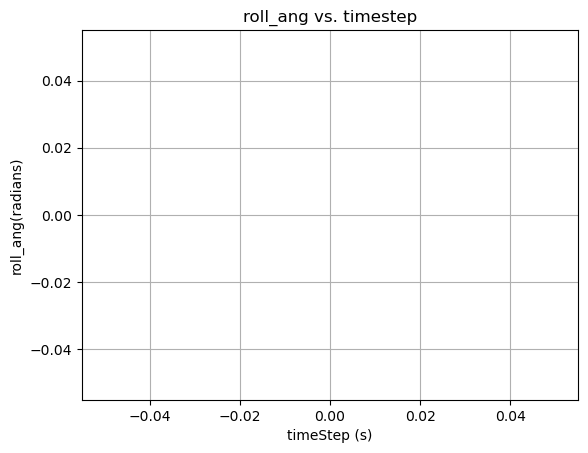

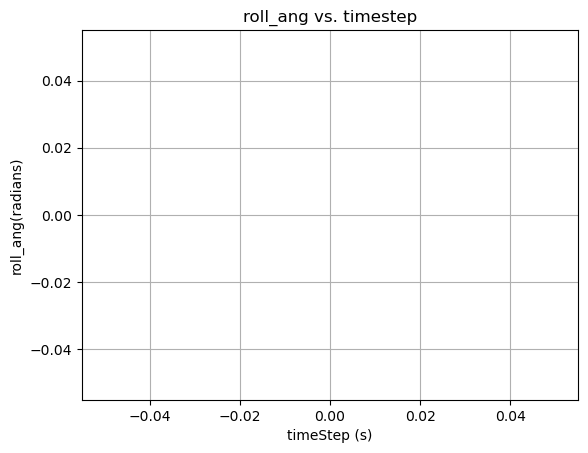

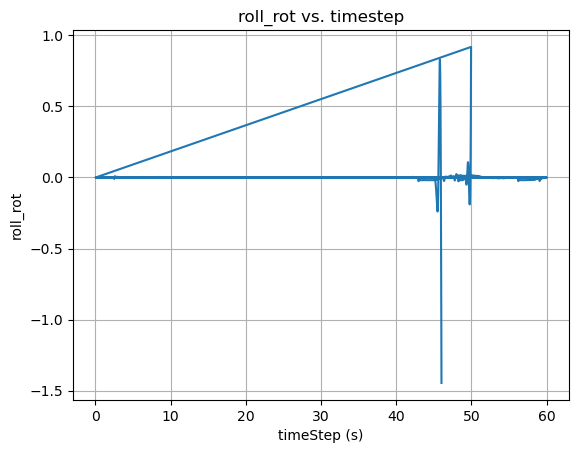

In [8]:
#plot roll-angle from integ. gyro:roll-vel vs. timestep
roll_ang = np.array(bot_stateDF["roll_ang"])
roll_rot = np.array(bot_stateDF["roll_rot"])#roll from IMU
timestep = np.array(bot_stateDF["timestep"])
print("length of roll ang: {}".format(len(roll_ang)))
print("length of timestep: {}".format(len(timestep)))
print(roll_ang[len(roll_ang) - 20:])
print(np.mean(roll_ang[len(roll_ang) - 20:]))

plt.plot(timestep[2805:2845], roll_ang[2805:2845])
plt.title("roll_ang vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("roll_ang(radians)")
plt.grid()
plt.show()

#plt.plot(timestep[200:], roll_ang[200:])
plt.plot(timestep[100:], roll_ang[100:])
plt.title("roll_ang vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("roll_ang(radians)")
plt.grid()
plt.show()

plt.plot(timestep[100:], roll_rot[100:])
plt.title("roll_rot vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("roll_rot")
plt.grid()
plt.show()

length of phi dot: 13494
length of timestep: 13494
[ 51.58225272  47.5632674   44.11231979  41.35486046  39.40780805
  38.37974801  38.37129725  39.47534935  39.98850171  43.56468244
  48.48350106  54.80408648  62.57789539  63.08845885  73.56651048
  85.03609246  97.43324928 110.78006942 119.5997198  118.63728504]
69.65457481977663


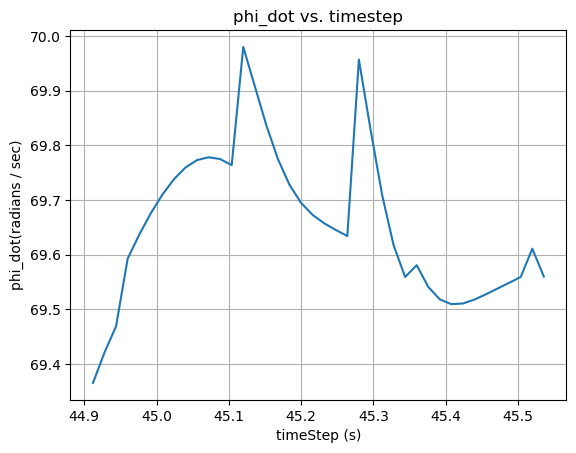

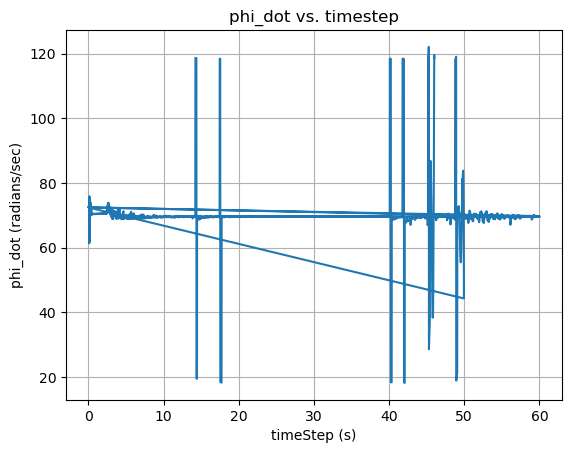

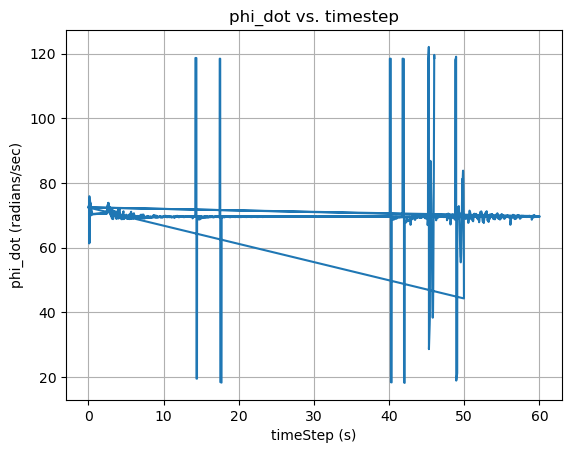

In [9]:
#plot phi-dot global roll velocity vs. timestep
phi_dot = np.array(bot_stateDF["phi_dot"])
timestep = np.array(bot_stateDF["timestep"])
print("length of phi dot: {}".format(len(phi_dot)))
print("length of timestep: {}".format(len(timestep)))
print(phi_dot[len(phi_dot) - 20:])
print(np.mean(phi_dot[2805:2845]))

plt.plot(timestep[2805:2845], phi_dot[2805:2845])
plt.title("phi_dot vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("phi_dot(radians / sec)")
plt.grid()
plt.show()

plt.plot(timestep[120:], phi_dot[120:])
plt.title("phi_dot vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("phi_dot (radians/sec)")
plt.grid()
plt.show()

plt.plot(timestep, phi_dot)
plt.title("phi_dot vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("phi_dot (radians/sec)")
plt.grid()
plt.show()

length of pitch vel: 13494
length of timestep: 13494
[-0.48613421 -0.71625586 -0.94182787 -1.16275707 -1.3797331  -1.59423532
 -1.80841652 -2.02484561 -2.24608792 -2.47409507 -2.70936907 -2.94986211
 -3.18958435 -3.39896524 -3.5817609  -3.70822767 -3.74591832 -3.660964
 -3.42223719 -3.00636706]
-0.0015500732523680229


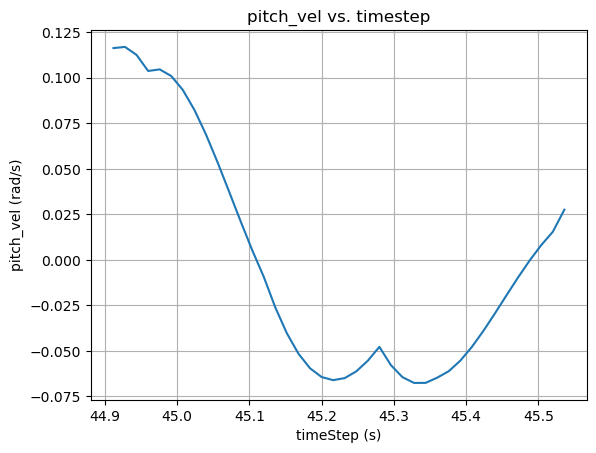

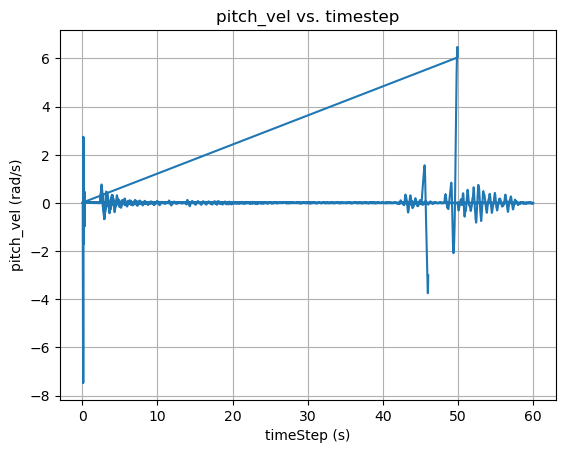

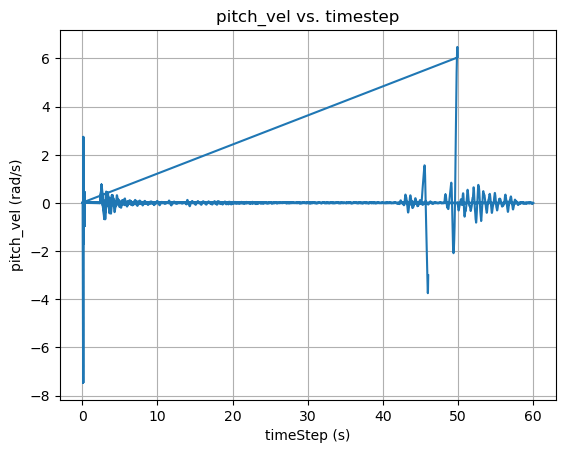

In [10]:
#plot pitch velocity from gyro vs. timestep
pitch_vel = np.array(bot_stateDF["pitch_vel"])
timestep = np.array(bot_stateDF["timestep"])
print("length of pitch vel: {}".format(len(pitch_vel)))
print("length of timestep: {}".format(len(timestep)))
print(pitch_vel[len(pitch_vel) - 20:])
print(np.mean(pitch_vel[2805:2845]))

plt.plot(timestep[2805:2845], pitch_vel[2805:2845])
plt.title("pitch_vel vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("pitch_vel (rad/s)")
plt.grid()
plt.show()

#plt.plot(timestep[400:], pitch_vel[400:])
plt.plot(timestep[400:], pitch_vel[400:])
plt.title("pitch_vel vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("pitch_vel (rad/s)")
plt.grid()
plt.show()

plt.plot(timestep, pitch_vel)
plt.title("pitch_vel vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("pitch_vel (rad/s)")
plt.grid()
plt.show()

In [11]:
pitch_integ_a = integrate.simpson(pitch_vel[2805:2845], timestep[2805:2845])
pitch_integ_b = integrate.simpson(pitch_vel[2805:2845], dx=0.016)
print(len(pitch_vel[2805:2845]))
print("pitch-vel(q) integrated over 20-timesteps: {} rads".format(pitch_integ_a))
print("pitch-vel(q) integrated using dx @ 0.016s: {} rads".format(pitch_integ_b))


pitch_integ_angl = np.multiply((float(180)/math.pi), pitch_integ_a)
print("integrated pitch angle: {:.9f} deg".format(pitch_integ_angl))

40
pitch-vel(q) integrated over 20-timesteps: -0.002158431837518779 rads
pitch-vel(q) integrated using dx @ 0.016s: -0.0021584318375188886 rads
integrated pitch angle: -0.123669035 deg


length of roll ang: 13494
length of timestep: 13494
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
nan


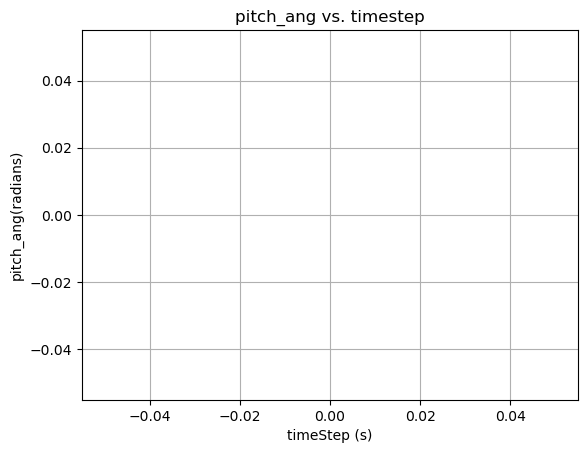

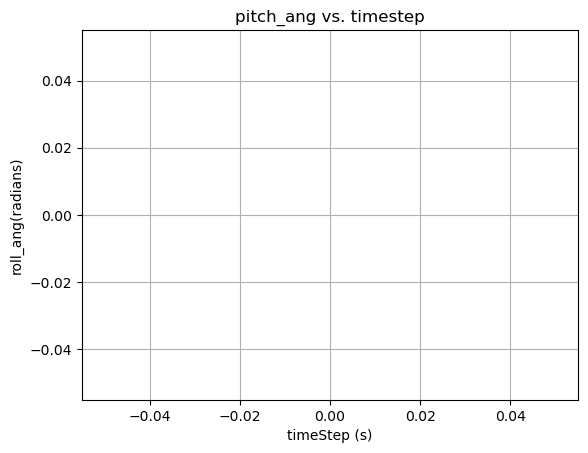

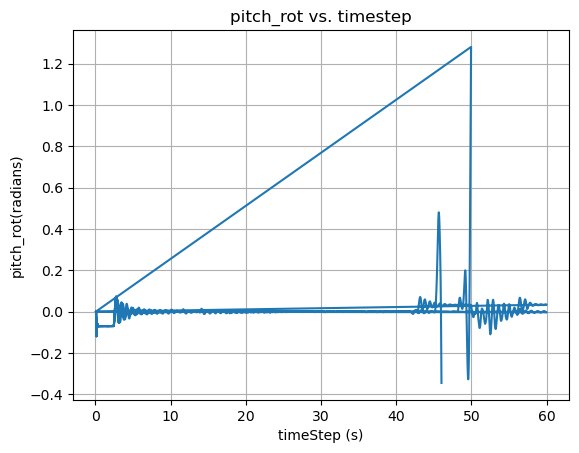

In [12]:
#plot local pitch-angle from integ. gyro: local pitch-vel vs. timestep
pitch_ang = np.array(bot_stateDF["pitch_ang"])
pitch_rot = np.array(bot_stateDF["pitch_rot"])
timestep = np.array(bot_stateDF["timestep"])
print("length of roll ang: {}".format(len(pitch_ang)))
print("length of timestep: {}".format(len(timestep)))
print(pitch_ang[len(pitch_ang) - 20:])
print(np.mean(pitch_ang[len(pitch_ang) - 20:]))

plt.plot(timestep[2805:2845], pitch_ang[2805:2845])
plt.title("pitch_ang vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("pitch_ang(radians)")
plt.grid()
plt.show()

plt.plot(timestep[100:], pitch_ang[100:])
plt.title("pitch_ang vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("roll_ang(radians)")
plt.grid()
plt.show()

plt.plot(timestep[100:], pitch_rot[100:])
plt.title("pitch_rot vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("pitch_rot(radians)")
plt.grid()
plt.show()

length of pitch vel: 13494
length of timestep: 13494
[ 5.38508492e-01  5.34162966e-01  5.25314735e-01  5.09129576e-01
  4.82000633e-01  4.39593621e-01  3.76854852e-01  2.87969547e-01
  1.66268484e-01  4.09762090e-03 -2.07310746e-01 -4.77893558e-01
 -8.18623367e-01 -1.23338106e+00 -1.72026349e+00 -2.27527980e+00
 -2.89102303e+00 -3.55191584e+00 -4.23282575e+00 -4.89869746e+00]
-0.9221656783639125


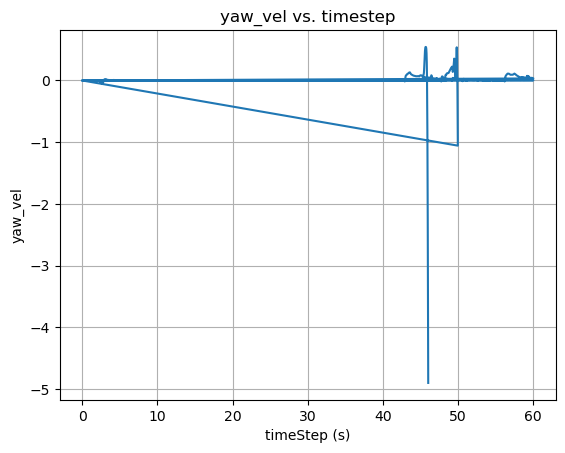

In [13]:
#plot yaw acceleration vs. timestep
yaw_vel = np.array(bot_stateDF["yaw_vel"])
timestep = np.array(bot_stateDF["timestep"])
print("length of pitch vel: {}".format(len(yaw_vel)))
print("length of timestep: {}".format(len(timestep)))
print(yaw_vel[len(yaw_vel) - 20:])
print(np.mean(yaw_vel[len(yaw_vel) - 20:]))

plt.plot(timestep, yaw_vel)
plt.title("yaw_vel vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("yaw_vel")
plt.grid()
plt.show()

In [14]:
yaw_integ_a = integrate.simpson(yaw_vel[2400:2420], timestep[2400:2420])
yaw_integ_b = integrate.simpson(yaw_vel[2400:2420], dx=0.016)
print(len(yaw_vel[2400:2420]))
print("yaw-vel(r) integrated over 20-timesteps: {} rads".format(yaw_integ_a))
print("yaw-vel(r) integrated using dx @ 0.016s: {} rads".format(yaw_integ_b))


yaw_integ_angl = np.multiply((float(180)/math.pi), yaw_integ_a)
print("integrated yaw angle: {:.6f} deg".format(yaw_integ_angl))

20
yaw-vel(r) integrated over 20-timesteps: -6.788801796951404e-06 rads
yaw-vel(r) integrated using dx @ 0.016s: -6.788801796951494e-06 rads
integrated yaw angle: -0.000389 deg


length of yaw ang: 13494
length of timestep: 13494
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
nan


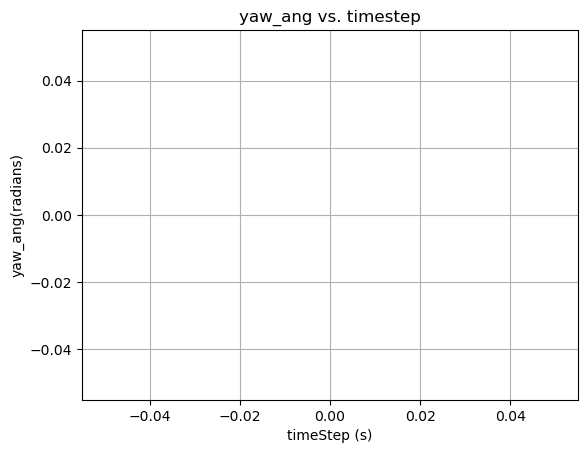

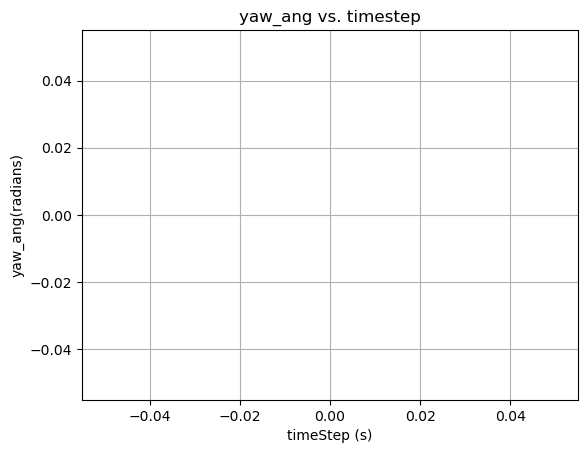

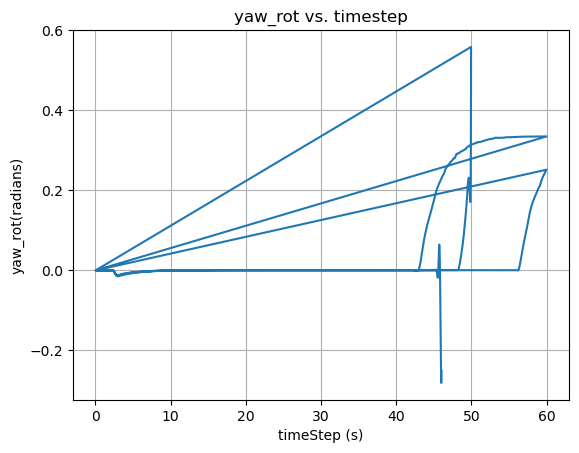

In [15]:
#plot local pitch-angle from integ. gyro: local pitch-vel vs. timestep
yaw_ang = np.array(bot_stateDF["yaw_ang"])
yaw_rot = np.array(bot_stateDF["yaw_rot"])
timestep = np.array(bot_stateDF["timestep"])
print("length of yaw ang: {}".format(len(yaw_ang)))
print("length of timestep: {}".format(len(timestep)))
print(yaw_ang[len(yaw_ang) - 20:])
print(np.mean(yaw_ang[len(yaw_ang) - 20:]))

plt.plot(timestep[2805:2845], yaw_ang[2805:2845])
plt.title("yaw_ang vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("yaw_ang(radians)")
plt.grid()
plt.show()

plt.plot(timestep[400:], yaw_ang[400:])
plt.title("yaw_ang vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("yaw_ang(radians)")
plt.grid()
plt.show()

plt.plot(timestep[400:], yaw_rot[400:])
plt.title("yaw_rot vs. timestep")
plt.xlabel("timeStep (s)")
plt.ylabel("yaw_rot(radians)")
plt.grid()
plt.show()

length of x_acc: 13494
length of timestep: 13494
x_acc-min: -49.49483130764169
x_acc-max: 47.14958613606823
[ 1.93494444e-01 -3.32283819e-02 -2.81919858e-02 -2.31781693e-02
 -1.87428677e-02 -2.87689566e+01  4.71495861e+01 -2.73502002e+00
 -2.97878358e+00 -3.31404269e+00 -3.52447645e+00 -3.39923179e+00
  1.16229481e+01 -3.23630109e+00 -3.26585383e+00  7.06519113e+00
 -3.18602819e+00  3.43006485e+00 -1.11600551e-01  6.72737697e-01
  6.81655656e-01  6.82370796e-01  6.82872139e-01  6.83271119e-01
  6.83589009e-01  6.83842053e-01  6.84043226e-01  6.84202892e-01
  6.84329335e-01  6.84429176e-01  6.84507706e-01  6.84569156e-01
  6.84616905e-01  6.84653656e-01  6.84681571e-01  6.84702377e-01
  6.84717454e-01  6.84727908e-01  6.84734621e-01  6.84738299e-01
  6.84739505e-01  6.84738693e-01  6.84736222e-01  6.84732381e-01
  6.84727400e-01  6.84721465e-01  6.84714722e-01  6.84707289e-01
  6.84699262e-01  6.84690715e-01]
[ 5.65019914e-03  3.39676681e-03  1.23201476e-03  4.33994145e-03
  1.51829102e

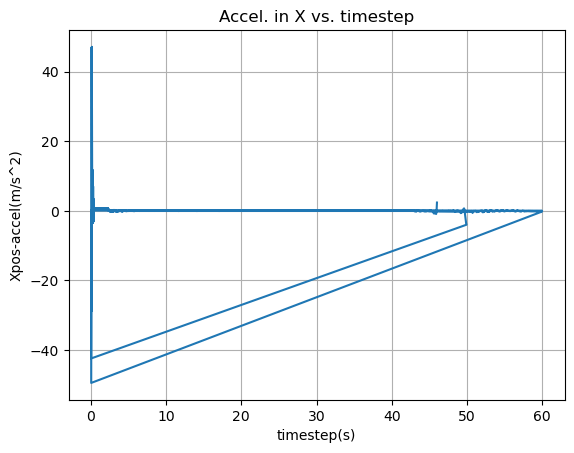

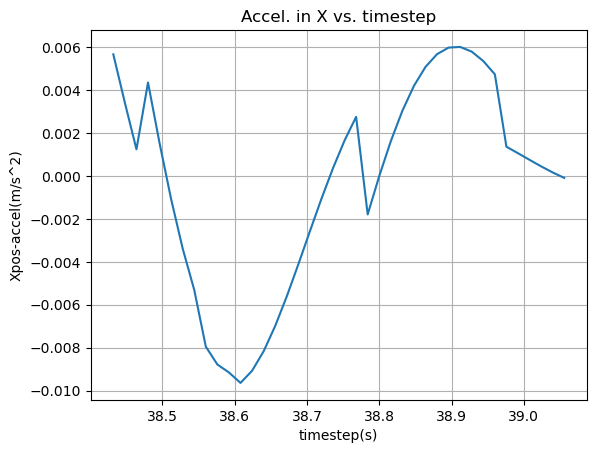

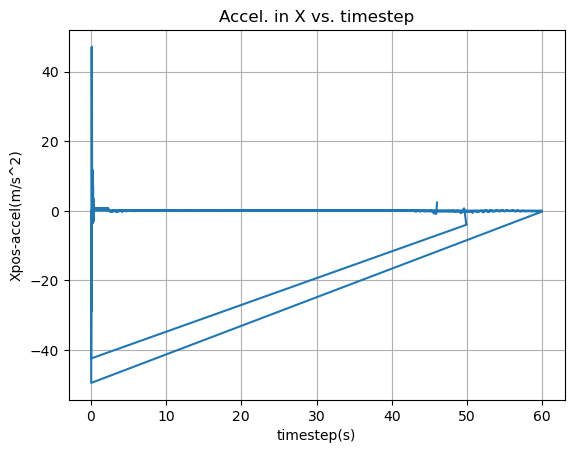

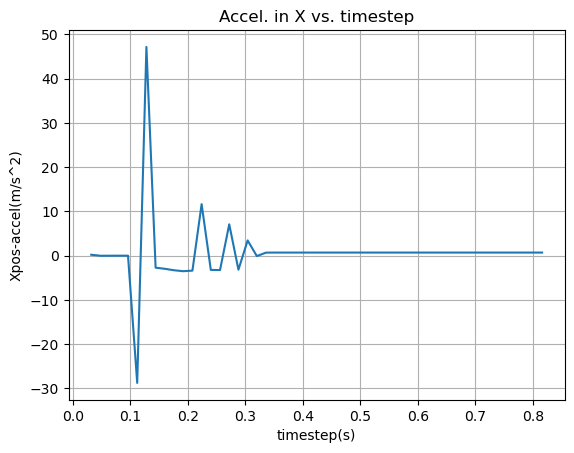

In [16]:
##Analyze integrating trans-acceleration into trans-velocity and into global velocity frme
###Plot x-acc vs timestep
x_acc = np.array(bot_stateDF["x_acc"])
timestep = np.array(bot_stateDF["timestep"])
print("length of x_acc: {}".format(len(x_acc)))
print("length of timestep: {}".format(len(timestep)))
print("x_acc-min: {}".format(x_acc.min()))
print("x_acc-max: {}".format(x_acc.max()))
print(x_acc[:50])
print(x_acc[2400:2440])
print(timestep[2400:2440])
print("x_acc at index: {}".format(x_acc[120]))


peakvals = []
for i, acc_val in enumerate(x_acc):
    if acc_val > 1 or acc_val < -1:
        peakvals.append((timestep[i], acc_val))
for peak in peakvals:
    print(peak)

plt.plot(timestep, x_acc)
#plt.plot(timestep[300:], x_acc[300:])
plt.title("Accel. in X vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("Xpos-accel(m/s^2)")
plt.grid()
plt.show()

plt.plot(timestep[2400:2440], x_acc[2400:2440])
#plt.plot(timestep[300:], x_acc[300:])
plt.title("Accel. in X vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("Xpos-accel(m/s^2)")
plt.grid()
plt.show()

plt.plot(timestep[200:], x_acc[200:])
plt.title("Accel. in X vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("Xpos-accel(m/s^2)")
plt.grid()
plt.show()

plt.plot(timestep[:50], x_acc[:50])
plt.title("Accel. in X vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("Xpos-accel(m/s^2)")
plt.grid()
plt.show()

length of x-vel: 13494
length of timestep: 13494
[1.0950124  1.15005819 1.20237725 1.25147629 1.29686312 1.33806367
 1.37464541 1.40624882 1.43263395 1.45375428 1.46987469 1.48174846
 1.49085418 1.49996251 1.51113956 1.5269465  1.55073274 1.58460392
 1.6284764  1.67941578]
0.5846274152314564


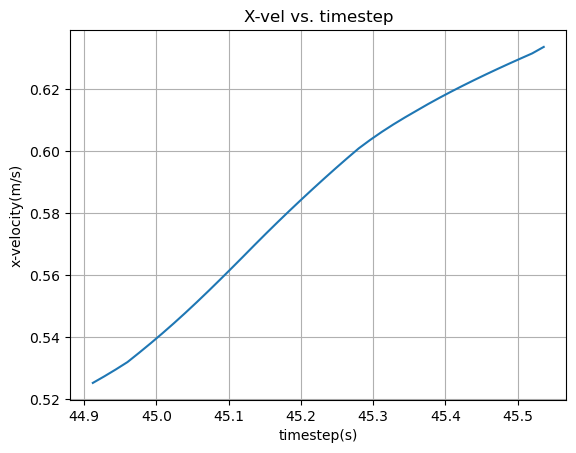

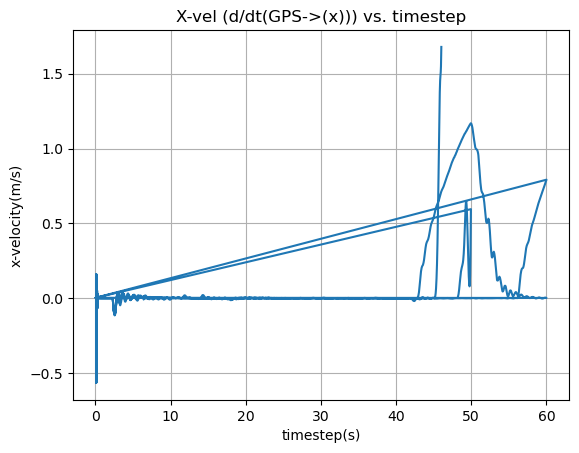

In [17]:
###Plot x-vel from (Xgps(t-1)-Xgps(t))/calcd_timestep vs timestep
x_vel = np.array(bot_stateDF["x_vel"])
timestep = np.array(bot_stateDF["timestep"])
print("length of x-vel: {}".format(len(x_vel)))
print("length of timestep: {}".format(len(timestep)))
print(x_vel[len(x_vel) - 20:])
print(np.mean(x_vel[2805:2845]))


plt.plot(timestep[2805:2845], x_vel[2805:2845])
plt.title("X-vel vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-velocity(m/s)")
plt.grid()
plt.show()

plt.plot(timestep[400:], x_vel[400:])
plt.title("X-vel (d/dt(GPS->(x))) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-velocity(m/s)")
plt.grid()
plt.show()

In [18]:
#x-vel from body and integrated over 40-samples of x-acceleration
x_vel_loc = integrate.simpson(x_acc[2805:2845], timestep[2805:2845])


#try integrate with xdot-global
#x_vel_loc = integrate.simpson(x_acc, timestep)
#x_vel_loc = integrate.cumulative_trapezoid(x_acc[2400:2440], timestep[2400:2440], initial=0) 
#x_vel_loc = integrate.trapezoid(x_acc[2400:2440], timestep[2400:2440])
print(len(x_acc[2805:2845]))
print("x-vel local fm integrated x-acc:\n{} m/s".format(x_vel_loc))
#print("x-vel local fm integrated x-acc: {:.5f} m/s".format(x_vel_loc))
print("x-vel in global-frame from GPS: {:.5f} m/s".format(np.mean(x_vel[2805:2845])))

40
x-vel local fm integrated x-acc:
-0.09406603877982078 m/s
x-vel in global-frame from GPS: 0.58463 m/s


length of x-vel local: 13494
length of timestep: 13494
[69.48700054 69.43133642 69.38322906 69.73327448 69.68934048 69.65021049
 69.61612607 69.58786033 69.56645082 69.55286063 69.54768081 69.55094561
 69.56208435 69.58987306 69.66180061 69.73358393 69.79517269 69.84225262
 69.87519978 69.89724297 69.91254035 69.92467668 69.93582384 69.53011627
 69.65688121 69.77663273 69.86954286 69.92782678 69.83190883 69.87163006
 69.89452394 69.90325379 69.90195988 69.89481424 69.88505999 69.8746141
 69.86414837 69.85347259 69.75732373 69.80842172]
at timestep: 44.912
69.74071744260068
69.93582384381081
a=44.912
b=45.552


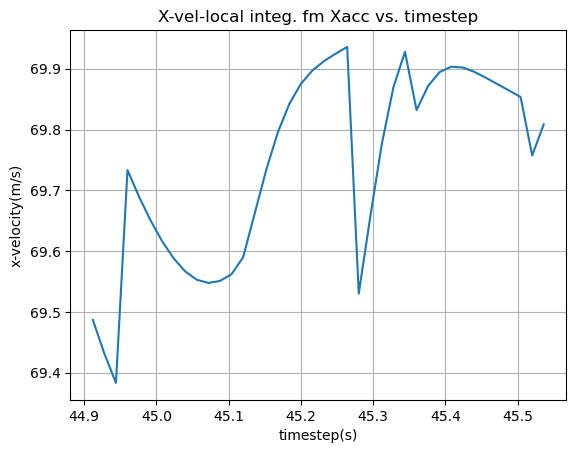

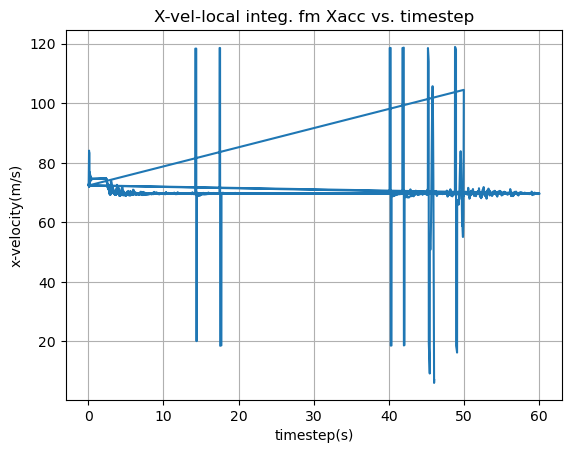

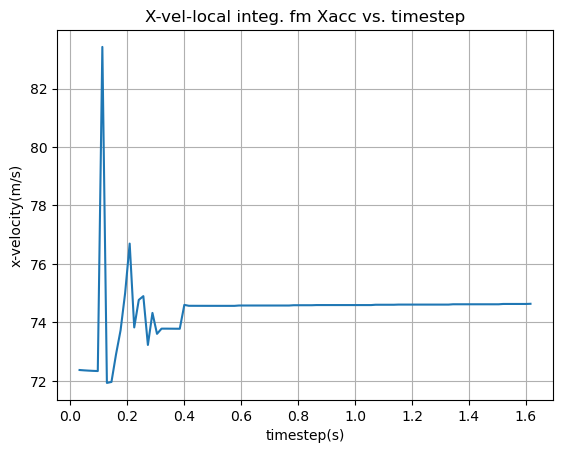

In [19]:
###Plot x-vel-local from integrated xacc vs timestep
x_vel_local = np.array(bot_stateDF["xvel_local"])
timestep = np.array(bot_stateDF["timestep"])
print("length of x-vel local: {}".format(len(x_vel_local)))
print("length of timestep: {}".format(len(timestep)))
print(x_vel_local[2805:2845])
print("at timestep: {}".format(timestep[2805]))
print(np.mean(x_vel_local[2805:2845]))
print(np.max(x_vel_local[2805:2845]))
print("a={}".format(timestep[2805]))
print("b={}".format(timestep[2845]))

plt.plot(timestep[2805:2845], x_vel_local[2805:2845])
plt.title("X-vel-local integ. fm Xacc vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-velocity(m/s)")
plt.grid()
plt.show()

plt.plot(timestep[170:], x_vel_local[170:])
plt.title("X-vel-local integ. fm Xacc vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-velocity(m/s)")
plt.grid()
plt.show()

plt.plot(timestep[:100], x_vel_local[:100])
plt.title("X-vel-local integ. fm Xacc vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-velocity(m/s)")
plt.grid()
plt.show()

length of x-dot-global: 13494
length of timestep: 13494
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
nan
a=44.912
b=45.552


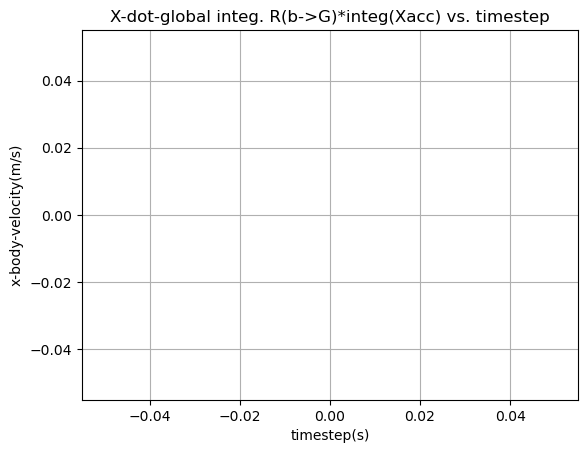

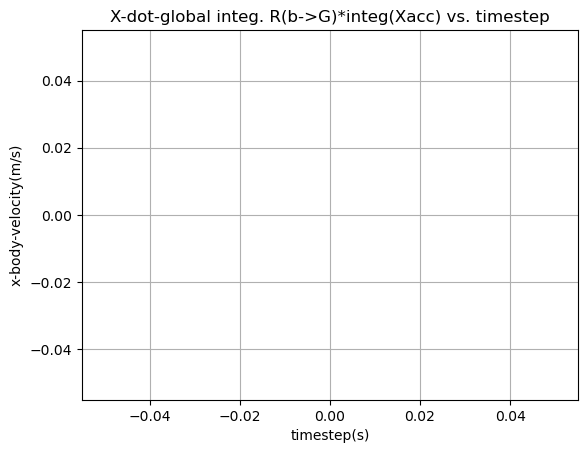

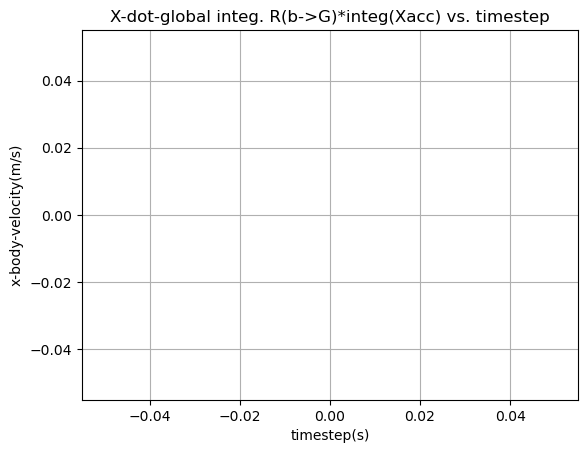

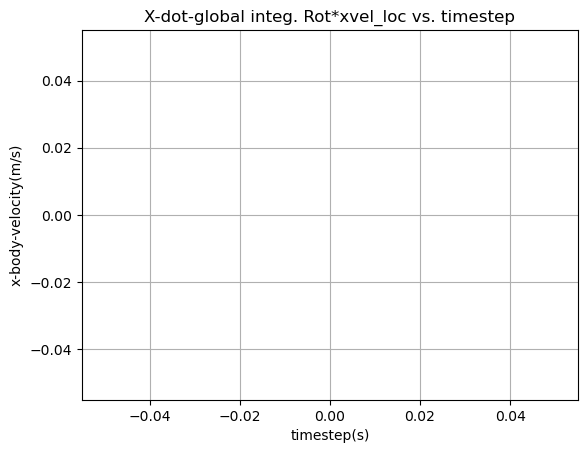

In [20]:
###Plot x-dot global from matmul(local2global rot-matrix, integ. x-acc)vs timestep
x_dot_global = np.array(bot_stateDF["xdot_global"])
x_pos = np.array(bot_stateDF["x_pos"])
x_pos_global = np.array(bot_stateDF["xpos_global"])
timestep = np.array(bot_stateDF["timestep"])
print("length of x-dot-global: {}".format(len(x_dot_global)))
print("length of timestep: {}".format(len(timestep)))
print(x_pos_global[2805:2845])
print(np.mean(x_dot_global[2805:2845]))
print("a={}".format(timestep[2805]))
print("b={}".format(timestep[2845]))


plt.plot(timestep[2805:2845], x_dot_global[2805:2845])
plt.title("X-dot-global integ. R(b->G)*integ(Xacc) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-body-velocity(m/s)")
plt.grid()
plt.show()

plt.plot(timestep[400:], x_dot_global[400:])
plt.title("X-dot-global integ. R(b->G)*integ(Xacc) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-body-velocity(m/s)")
plt.grid()
plt.show()

plt.plot(timestep[170:], x_dot_global[170:])
plt.title("X-dot-global integ. R(b->G)*integ(Xacc) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-body-velocity(m/s)")
plt.grid()
plt.show()

plt.plot(timestep[:50], x_dot_global[:50])
plt.title("X-dot-global integ. Rot*xvel_loc vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-body-velocity(m/s)")
plt.grid()
plt.show()

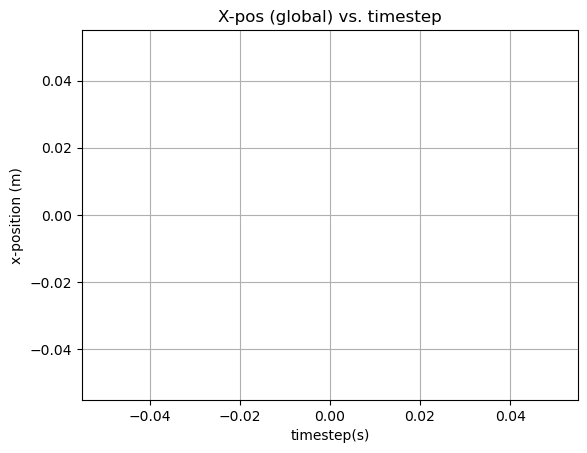

[nan nan nan nan nan nan nan nan nan nan]
nan


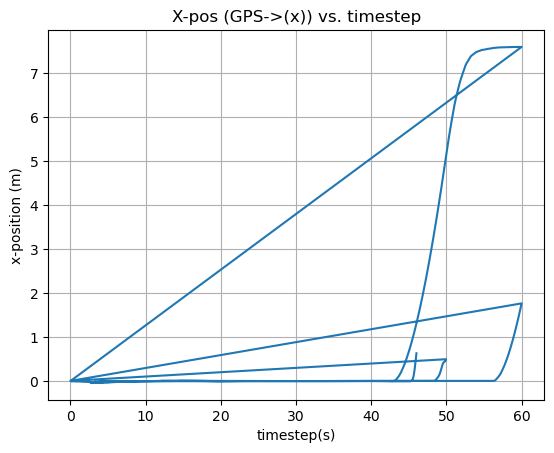

0.6274616110645883


In [21]:
plt.plot(timestep[100:], x_pos_global[100:])
plt.title("X-pos (global) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-position (m)")
plt.grid()
plt.show()
print(x_pos_global[:10])
print(x_pos_global[0])


plt.plot(timestep[100:], x_pos[100:])
plt.title("X-pos (GPS->(x)) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("x-position (m)")
plt.grid()
plt.show()
print(x_pos[len(x_pos)-1])

In [22]:
print(len(timestep))
xpos_est = 0
error_sum = 0

i=100
while i in range(len(timestep)-40):
    integ_val = integrate.simpson(x_dot_global[i:i+40], timestep[i:i+40]) / 10
    if integ_val > 0.04 or integ_val < -0.04:
        print("found overval at {}: {}".format(i, integ_val))
        error_sum += integ_val
        xpos_est += 0
        print(xpos_est)
    else:
        xpos_est += integ_val
    
    if i % 100 == 0:
        print("integrated value at {}: {}".format(i, integ_val))
        print("accumulated est'd xpos: {}".format(xpos_est))
    i += 1
        
print(x_dot_global[36:101])
print("final error sum: {}".format(error_sum))
print("summed est'd xpos: {}".format(xpos_est))
print("error sum and estd xpos diff(drop 1mag): {}".format((xpos_est - error_sum)))

13494
integrated value at 100: nan
accumulated est'd xpos: nan
integrated value at 200: nan
accumulated est'd xpos: nan
integrated value at 300: nan
accumulated est'd xpos: nan
integrated value at 400: nan
accumulated est'd xpos: nan
integrated value at 500: nan
accumulated est'd xpos: nan
integrated value at 600: nan
accumulated est'd xpos: nan
integrated value at 700: nan
accumulated est'd xpos: nan
integrated value at 800: nan
accumulated est'd xpos: nan
integrated value at 900: nan
accumulated est'd xpos: nan
integrated value at 1000: nan
accumulated est'd xpos: nan
integrated value at 1100: nan
accumulated est'd xpos: nan
integrated value at 1200: nan
accumulated est'd xpos: nan
integrated value at 1300: nan
accumulated est'd xpos: nan
integrated value at 1400: nan
accumulated est'd xpos: nan
integrated value at 1500: nan
accumulated est'd xpos: nan
integrated value at 1600: nan
accumulated est'd xpos: nan
integrated value at 1700: nan
accumulated est'd xpos: nan
integrated value 

length of y_acc: 13494
length of timestep: 13494
y_acc-min: -28.293263683681765
[4.09656931 3.97929548 3.83745473 3.62690037 3.30570854]


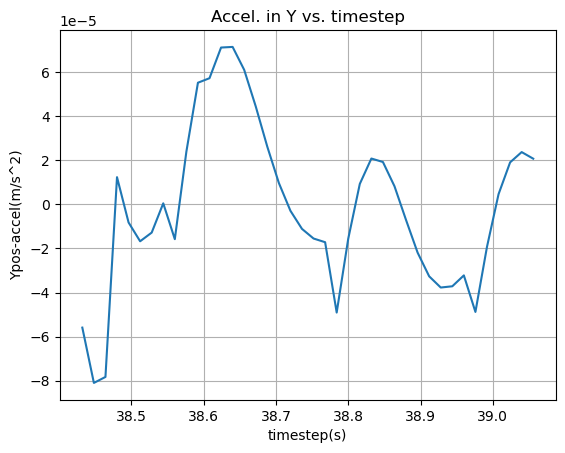

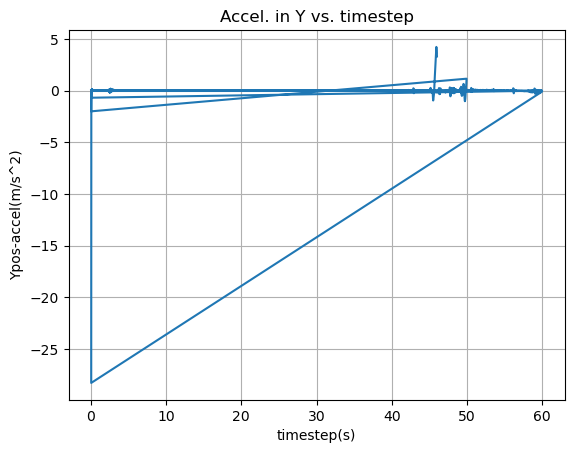

In [23]:
###Plot y-acc vs timestep
y_acc = np.array(bot_stateDF["y_acc"])
timestep = np.array(bot_stateDF["timestep"])
print("length of y_acc: {}".format(len(y_acc)))
print("length of timestep: {}".format(len(timestep)))
print("y_acc-min: {}".format(y_acc.min()))
print(y_acc[len(y_acc) - 5:])

plt.plot(timestep[2400:2440], y_acc[2400:2440])
plt.title("Accel. in Y vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("Ypos-accel(m/s^2)")
plt.grid()
plt.show()

plt.plot(timestep, y_acc)
plt.title("Accel. in Y vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("Ypos-accel(m/s^2)")
plt.grid()
plt.show()

length of y-vel: 13494
length of timestep: 13494
[ 0.12295265  0.0485252  -0.03347427 -0.1219464  -0.21531075 -0.31140325
 -0.40736298 -0.49951703 -0.58328858 -0.65318339 -0.70295718 -0.72612875
 -0.71706397 -0.67516502 -0.60532132 -0.52324457 -0.44423099 -0.38578633
 -0.36299114 -0.3828645 ]


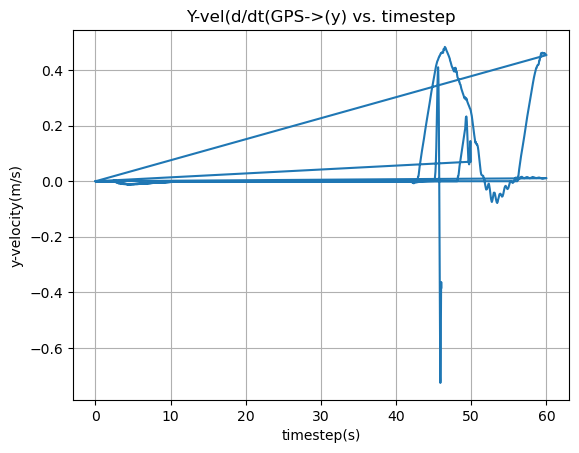

In [24]:
###Plot y-vel vs timestep
y_vel = np.array(bot_stateDF["y_vel"])
timestep = np.array(bot_stateDF["timestep"])
print("length of y-vel: {}".format(len(y_vel)))
print("length of timestep: {}".format(len(timestep)))
print(y_vel[len(y_vel) - 20:])

plt.plot(timestep, y_vel)
plt.title("Y-vel(d/dt(GPS->(y) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("y-velocity(m/s)")
plt.grid()
plt.show()

In [25]:
#y-vel from body and integrated over 40-samples of y-acceleration
y_vel_loc = integrate.simpson(y_acc[2400:2440], timestep[2400:2440])
print(len(y_acc[2400:2440]))
print("y-vel local fm integrated y-acc: {:.5f} m/s".format(y_vel_loc))
print("y-vel in global-frame from GPS: {:.5f} m/s".format(np.mean(y_vel[2400:2440])))

40
y-vel local fm integrated y-acc: -0.00000 m/s
y-vel in global-frame from GPS: 0.00000 m/s


length of y-vel: 13494
length of timestep: 13494
last 40 in yvel-local:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
yvel-local avg: nan
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]


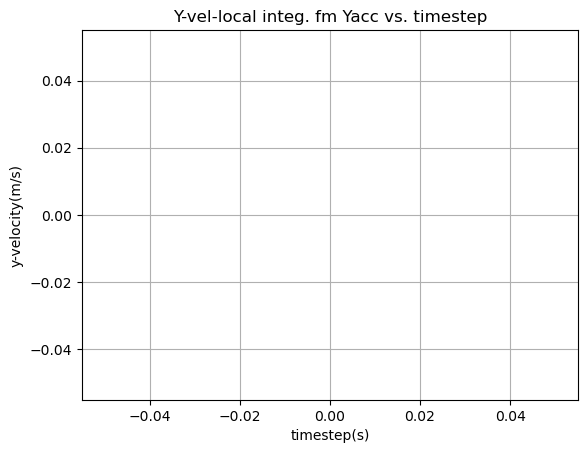

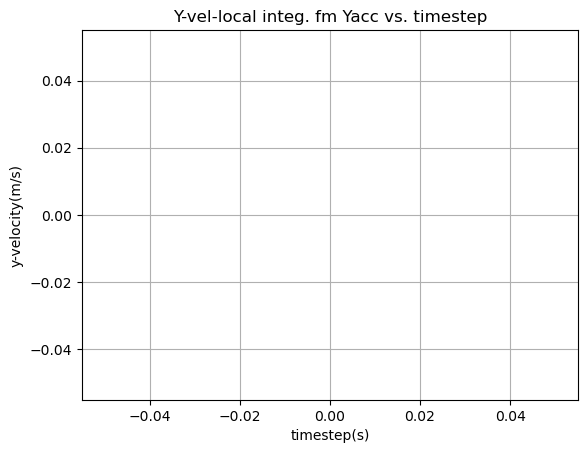

In [26]:
###Plot y-vel-local from integrated yacc vs timestep
y_vel_local = np.array(bot_stateDF["yvel_local"])
timestep = np.array(bot_stateDF["timestep"])
print("length of y-vel: {}".format(len(y_vel_local)))
print("length of timestep: {}".format(len(timestep)))
print("last 40 in yvel-local:\n{}".format(y_vel_local[len(y_vel_local) - 40:]))
print("yvel-local avg: {:.9f}".format(np.min(y_vel_local[2805:2845])))
print(y_vel_local[2400:2440])

plt.plot(timestep[2400:2440], y_vel_local[2400:2440])
plt.title("Y-vel-local integ. fm Yacc vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("y-velocity(m/s)")
plt.grid()
plt.show()

plt.plot(timestep[400:], y_vel_local[400:])
plt.title("Y-vel-local integ. fm Yacc vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("y-velocity(m/s)")
plt.grid()
plt.show()

length of y-dot-global: 13494
length of timestep: 13494
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
nan
a=38.432
b=39.072


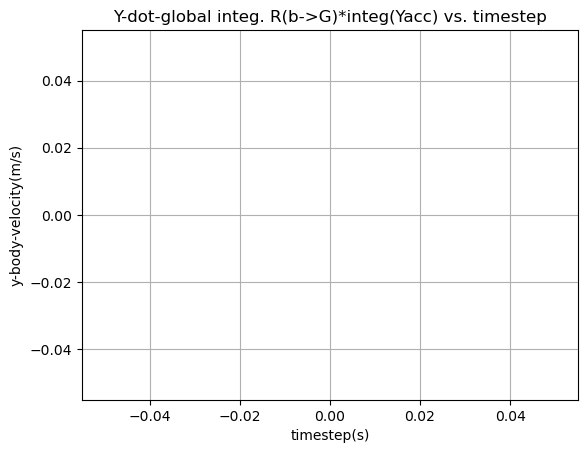

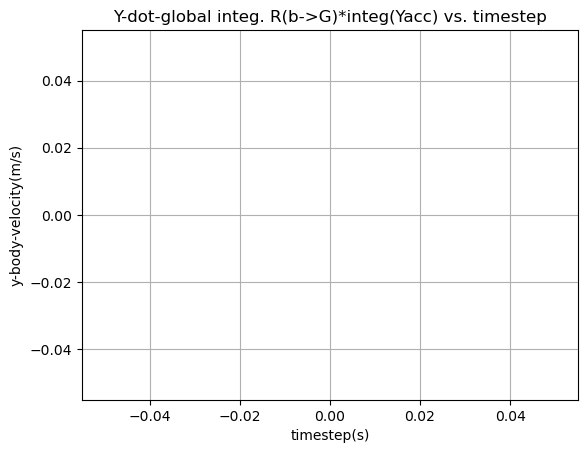

40
y-pos local fm integrated y-dot-global local: nan m/s
y-pos in global-frame from GPS: -0.05901 m/s


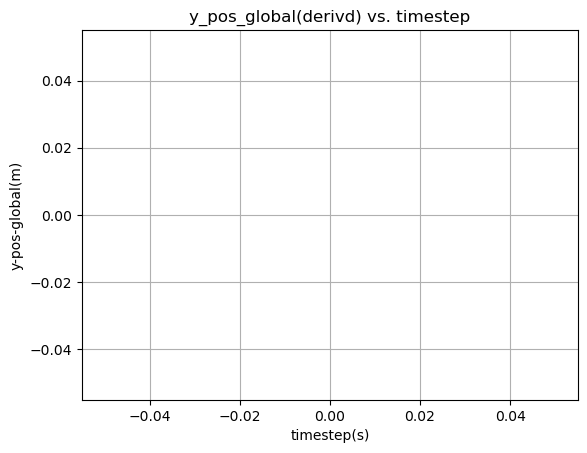

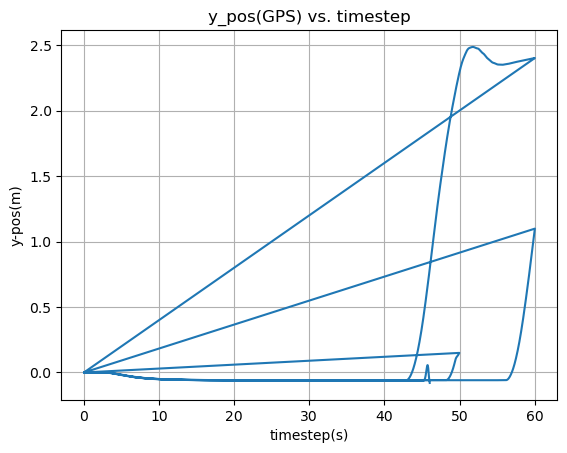

In [27]:
###Plot y-dot global from matmul(local2global rot-matrix, integ. y-acc)vs timestep
y_dot_global = np.array(bot_stateDF["ydot_global"])
y_pos = np.array(bot_stateDF["y_pos"])
y_pos_global = np.array(bot_stateDF["ypos_global"])
timestep = np.array(bot_stateDF["timestep"])
print("length of y-dot-global: {}".format(len(y_dot_global)))
print("length of timestep: {}".format(len(timestep)))
print(y_dot_global[2400:2440])
print(np.mean(y_dot_global[2400:2440]))
print("a={}".format(timestep[2400]))
print("b={}".format(timestep[2440]))

plt.plot(timestep[2400:2440], y_dot_global[2400:2440])
plt.title("Y-dot-global integ. R(b->G)*integ(Yacc) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("y-body-velocity(m/s)")
plt.grid()
plt.show()

plt.plot(timestep[400:], y_dot_global[400:])
plt.title("Y-dot-global integ. R(b->G)*integ(Yacc) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("y-body-velocity(m/s)")
plt.grid()
plt.show()

#y-vel from body and integrated over 40-samples of y-acceleration
y_pos_loc = integrate.simpson(y_dot_global[2400:2440], timestep[2400:2440])
print(len(y_dot_global[2400:2440]))
print("y-pos local fm integrated y-dot-global local: {:.5f} m/s".format(y_pos_loc))
print("y-pos in global-frame from GPS: {:.5f} m/s".format(np.mean(y_pos[2400:2440])))


plt.plot(timestep[400:], y_pos_global[400:])
plt.title("y_pos_global(derivd) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("y-pos-global(m)")
plt.grid()
plt.show()

plt.plot(timestep[400:], y_pos[400:])
plt.title("y_pos(GPS) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("y-pos(m)")
plt.grid()
plt.show()

length of alt_acc: 13494
length of timestep: 13494
alt_acc-min: -0.8328211858656298
[9.78190318 9.80270931 9.82175886 9.83841102 9.81688469 9.83394584
 9.84890153 9.86131556 9.87088352 9.87744245 9.88097006 9.88157688
 9.87949196 9.87504323 9.88664106 9.87620314 9.86450619 9.85224483
 9.83999699 9.82824393 9.81738588 9.80774692 9.79957634 9.79305111
 9.85319537 9.83943478 9.82604136 9.81373758 9.80292819 9.79901754
 9.7905151  9.78383437 9.77905103 9.77615021 9.77504359 9.77558553
 9.77758781 9.78083179 9.78507696 9.77097768]


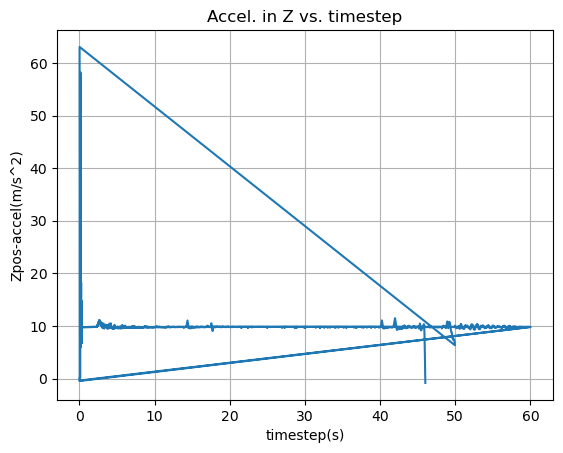

In [28]:
###Plot alt-acc vs timestep
alt_acc = np.array(bot_stateDF["alt_acc"])
timestep = np.array(bot_stateDF["timestep"])
print("length of alt_acc: {}".format(len(alt_acc)))
print("length of timestep: {}".format(len(timestep)))
print("alt_acc-min: {}".format(alt_acc.min()))
print(alt_acc[2805:2845])

plt.plot(timestep[20:], alt_acc[20:])
#plt.plot(timestep[100:], alt_acc[100:])
plt.title("Accel. in Z vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("Zpos-accel(m/s^2)")
plt.grid()
plt.show()

length of alt-vel: 13494
length of timestep: 13494
zvel-min: -1.4408727952380964
[-0.3360804  -0.36427109 -0.39320562 -0.42202209 -0.4496865  -0.47500485
 -0.49669742 -0.51357064 -0.5248267  -0.530549   -0.53238377 -0.53438663
 -0.54389348 -0.57237143 -0.63177676 -0.73111815 -0.87211499 -1.04872701
 -1.24585708 -1.4408728 ]
avg-zvel: 0.00506


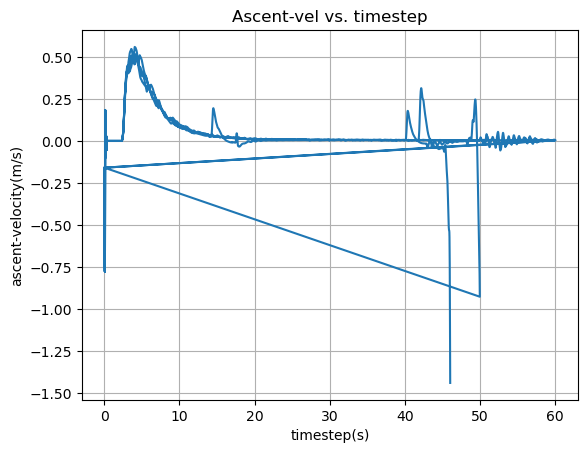

In [29]:
###Plot z-vel vs timestep
z_vel = np.array(bot_stateDF["alt_vel"])
timestep = np.array(bot_stateDF["timestep"])
print("length of alt-vel: {}".format(len(z_vel)))
print("length of timestep: {}".format(len(timestep)))
print("zvel-min: {}".format(z_vel.min()))
print(z_vel[len(z_vel) - 20:])
print("avg-zvel: {:.5f}".format(np.mean(z_vel[2400:2420])))

plt.plot(timestep, z_vel)
plt.title("Ascent-vel vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("ascent-velocity(m/s)")
plt.grid()
plt.show()

In [30]:
#z-vel from body and integrated over 40-samples of z-acceleration
quadrotor_mass = 0.407
z_vel_loc = integrate.simpson(np.subtract(alt_acc[2805:2845], (9.81)), timestep[2805:2845])
#z_vel_loc = integrate.simpson(alt_acc[2805:2845], timestep[2805:2845])
print(len(alt_acc[2805:2845]))
print("z-vel local fm integrated alt-acc: {:.9f} m/s".format(z_vel_loc))
print("z-vel in global-frame from GPS: {:.5f} m/s".format(np.mean(z_vel[2805:2845])))

40
z-vel local fm integrated alt-acc: 0.009636988 m/s
z-vel in global-frame from GPS: -0.01284 m/s


length of z-vel: 13494
length of timestep: 13494
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
sample avg for zvel-local: nan
sample max for zvel-local: nan


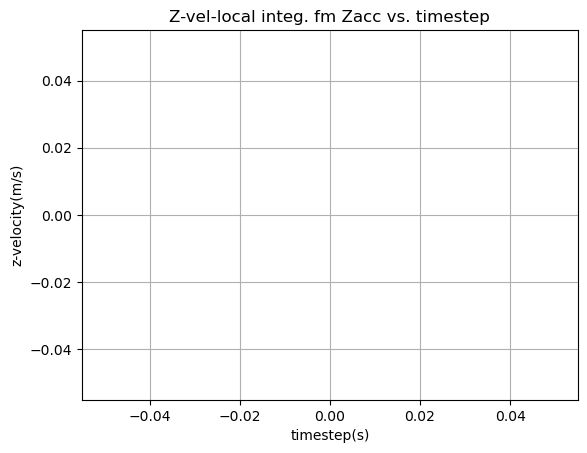

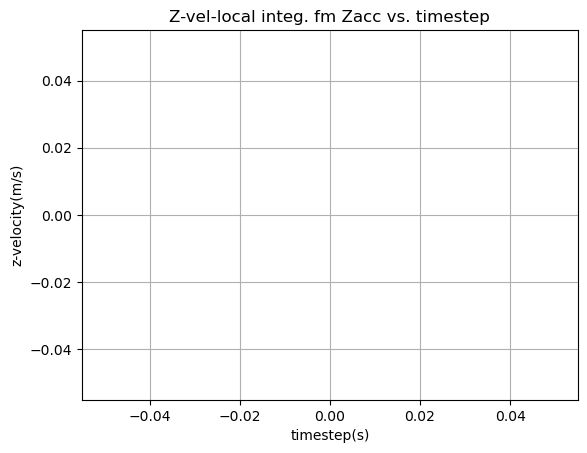

In [31]:
###Plot z-vel-local from integrated alt-acc vs timestep
z_vel_local = np.array(bot_stateDF["zvel_local"])
timestep = np.array(bot_stateDF["timestep"])
print("length of z-vel: {}".format(len(z_vel_local)))
print("length of timestep: {}".format(len(timestep)))
print(z_vel_local[len(z_vel_local) - 40:])
print("sample avg for zvel-local: {}".format(np.mean(z_vel_local[2805:2845])))
print("sample max for zvel-local: {}".format(np.max(z_vel_local[2805:2845])))

plt.plot(timestep[2805:2845], z_vel_local[2805:2845])
plt.title("Z-vel-local integ. fm Zacc vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("z-velocity(m/s)")
plt.grid()
plt.show()

plt.plot(timestep[100:], z_vel_local[100:])
plt.title("Z-vel-local integ. fm Zacc vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("z-velocity(m/s)")
plt.grid()
plt.show()

length of z-dot: 13494
length of timestep: 13494
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
nan
nan


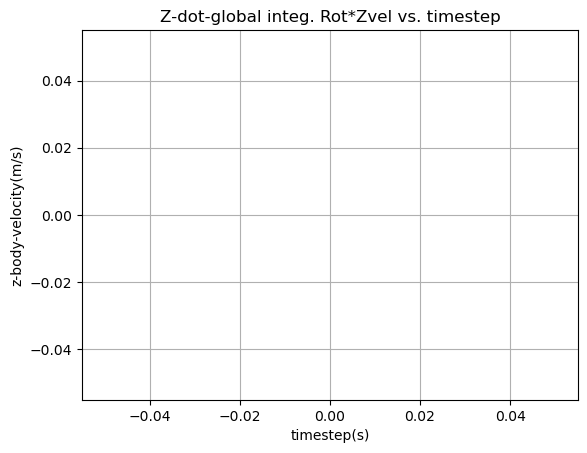

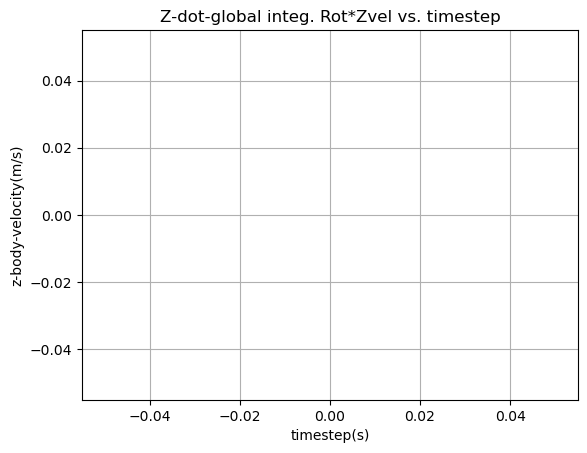

In [32]:
###Plot z-dot global from matmul(local2global rot-matrix, integ. z-acc)vs timestep
z_dot_global = np.array(bot_stateDF["zdot_global"])
timestep = np.array(bot_stateDF["timestep"])
print("length of z-dot: {}".format(len(z_dot_global)))
print("length of timestep: {}".format(len(timestep)))
print(z_dot_global[len(z_dot_global) - 40:])
print(np.mean(z_dot_global[2400:2440]))
print(np.max(z_dot_global[2400:2440]))

plt.plot(timestep[2400:2440], z_dot_global[2400:2440])
plt.title("Z-dot-global integ. Rot*Zvel vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("z-body-velocity(m/s)")
plt.grid()
plt.show()

plt.plot(timestep[400:], z_vel_local[400:])
plt.title("Z-dot-global integ. Rot*Zvel vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("z-body-velocity(m/s)")
plt.grid()
plt.show()

length of zpos: 13494
length of timestep: 13494
zpos-min: 0.1115790757910093
[2.71451446 2.70160844 2.68599847 2.66718239 2.64497401]
[nan nan nan nan nan nan nan nan nan nan]


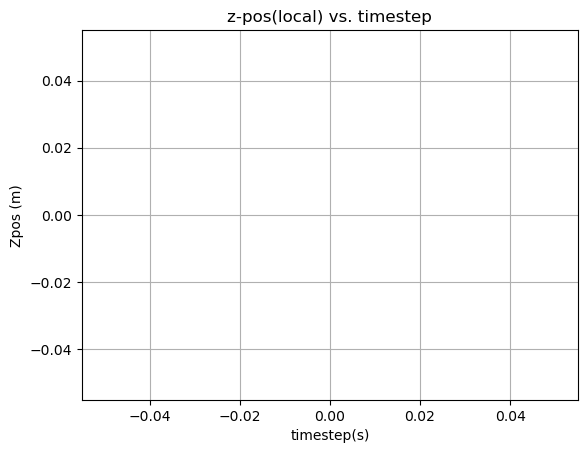

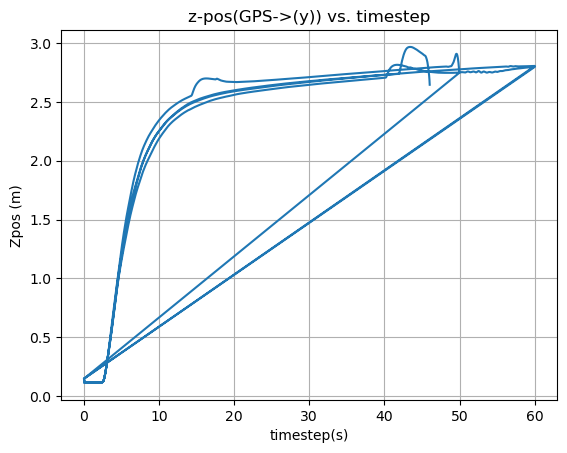

In [33]:
###Plot alt-acc vs timestep
zpos = np.array(bot_stateDF["z_pos"])
zpos_local = np.array(bot_stateDF["zpos_global"])
timestep = np.array(bot_stateDF["timestep"])
print("length of zpos: {}".format(len(zpos)))
print("length of timestep: {}".format(len(timestep)))
print("zpos-min: {}".format(zpos.min()))
print(zpos[len(zpos) - 5:])
print(zpos_local[:10])


plt.plot(timestep[100:], zpos_local[100:])
plt.title("z-pos(local) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("Zpos (m)")
plt.grid()
plt.show()

plt.plot(timestep[100:], zpos[100:])
plt.title("z-pos(GPS->(y)) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("Zpos (m)")
plt.grid()
plt.show()

In [34]:
local2global_rot_matrix = getLocalToGlobalRotation(roll_integ_a, pitch_integ_a, yaw_integ_a)
print("local2global rot. matrix:\n{}".format(local2global_rot_matrix))

local2global rot. matrix:
[[ 9.99987721e-01 -3.90744243e-06 -2.15843730e-03]
 [-6.78878598e-06  9.99987721e-01 -4.95551324e-03]
 [ 2.15843016e-03  4.95551635e-03  9.99985392e-01]]


In [35]:
xgps_global = np.mean(x_vel[2400:2440])
ygps_global = np.mean(y_vel[2400:2440])
zgps_global = np.mean(z_vel[2400:2440])


gps_vel_arr = np.array([xgps_global, ygps_global, zgps_global])
local_vel_arr = np.array([x_vel_loc, y_vel_loc, z_vel_loc])
bot_vel_global = np.matmul(local2global_rot_matrix, local_vel_arr)
print("bot-vel in local-frame(post-integration from Accel.):\n{}".format(local_vel_arr))
print("bot-vel in global-frame(apply Rot(loc->glob)):\n{}".format(bot_vel_global))
print("bot-vel in gps-global-frame(True Velocity from Sim):\n{}".format(gps_vel_arr))

bot-vel in local-frame(post-integration from Accel.):
[-9.40660388e-02 -7.09818860e-07  9.63698825e-03]
bot-vel in global-frame(apply Rot(loc->glob)):
[-9.40856846e-02 -4.78274388e-05  9.43380898e-03]
bot-vel in gps-global-frame(True Velocity from Sim):
[-1.25450576e-03  3.52738324e-06  5.83347494e-03]


In [36]:
print(x_dot_global[2805:2845])
print("xdot-global sample avg.: {} m/s".format(np.mean(x_dot_global[2805:2845])))
print("xdot-global sample max: {}".format(np.max(x_dot_global[2805:2845])))
xpos_derive = integrate.simpson(x_dot_global[2805:2845], timestep[2805:2845])
print("xpos_global: {}".format(xpos_derive))

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
xdot-global sample avg.: nan m/s
xdot-global sample max: nan
xpos_global: nan


length of xpos: 13494
length of timestep: 13494
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
nan
nan


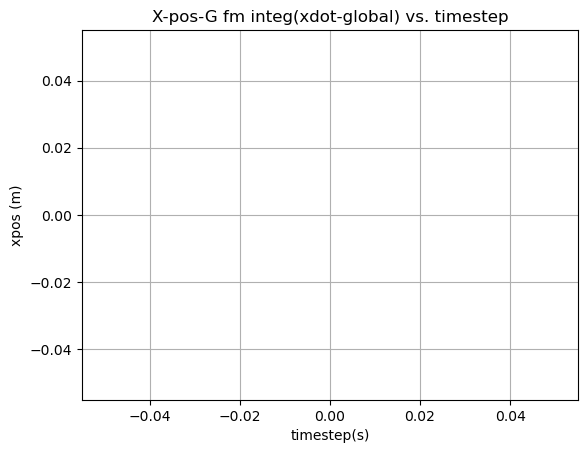

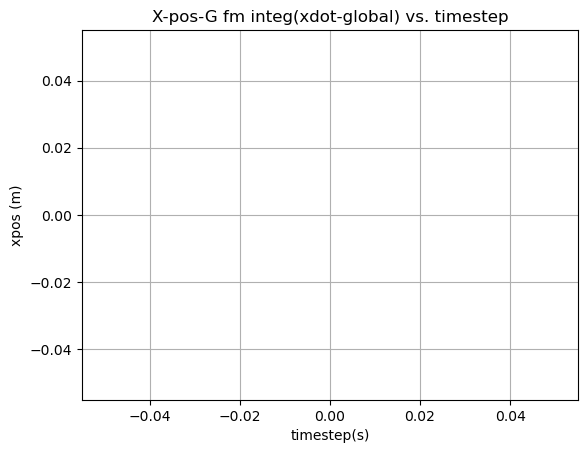

In [37]:
###Plot xpos-global integ. from xdot-global vs timestep
xpos_global = np.array(bot_stateDF["xpos_global"])
timestep = np.array(bot_stateDF["timestep"])
print("length of xpos: {}".format(len(xpos_global)))
print("length of timestep: {}".format(len(timestep)))
print(xpos_global[len(xpos_global) - 40:])
print(np.mean(xpos_global[2805:2845]))
print(np.max(xpos_global[2805:2845]))

plt.plot(timestep[2805:2845], xpos_global[2805:2845])
plt.title("X-pos-G fm integ(xdot-global) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("xpos (m)")
plt.grid()
plt.show()

plt.plot(timestep[400:], xpos_global[400:])
plt.title("X-pos-G fm integ(xdot-global) vs. timestep")
plt.xlabel("timestep(s)")
plt.ylabel("xpos (m)")
plt.grid()
plt.show()

In [38]:
#get gyro-meas. (rollvel, pitchvel, yawvel)
rollvel_arr = roll_vel[2805:2845]
pitchvel_arr = pitch_vel[2805:2845]
yawvel_arr = yaw_vel[2805:2845]
gyro_meas = np.array([rollvel_arr, pitchvel_arr, yawvel_arr])
#print(gyro_meas)
print(gyro_meas.shape)
#print(gyro_meas.transpose())
print(gyro_meas.transpose().shape)

#get accel-meas(xacc, yacc, zacc)
xacc_arr = x_acc[2805:2845]
yacc_arr = y_acc[2805:2845]
zacc_arr = alt_acc[2805:2845]
acc_meas = np.array([xacc_arr, yacc_arr, zacc_arr])
print(acc_meas.shape)
#print(acc_meas.transpose())
print(acc_meas.transpose().shape)

#create Complementary Filter
complem_filter = Complementary(gyr=gyro_meas.transpose(), acc=acc_meas.transpose())
comp_fltr_quats = quat.QuaternionArray(q=complem_filter.Q)
#print("comp-filter in quaternions:\n{}".format(comp_fltr_quats))
print(type(comp_fltr_quats))
comp_fltr_angs = comp_fltr_quats.to_angles()
#print("comp-filter in angles:\n{}".format(comp_fltr_angs))
print(type(comp_fltr_angs))
comp_fltr_ang_trans = comp_fltr_angs.transpose()
print(comp_fltr_ang_trans)
roll_eul_ang = comp_fltr_ang_trans[0]
pitch_eul_ang = comp_fltr_ang_trans[1]
yaw_eul_ang = comp_fltr_ang_trans[2]
print("roll euler angle (mean of 40 samples): {} radians".format(np.mean(roll_eul_ang)))
print("pitch euler angle (mean of 40 samples): {} radians".format(np.mean(pitch_eul_ang)))
print("yaw euler angle (mean of 40 samples): {} radians".format(np.mean(yaw_eul_ang)))






(3, 40)
(40, 3)
(3, 40)
(40, 3)
<class 'ahrs.common.quaternion.QuaternionArray'>
<class 'numpy.ndarray'>
[[-5.48883283e-03 -5.49014058e-03 -5.46923232e-03 -5.43389398e-03
  -5.51783898e-03 -5.53639549e-03 -5.52634564e-03 -5.51881058e-03
  -5.53359216e-03 -5.57801215e-03 -5.64913714e-03 -5.73778996e-03
  -5.83281337e-03 -5.92446787e-03 -6.27284627e-03 -6.21139912e-03
  -5.93349155e-03 -5.62166735e-03 -5.40661767e-03 -5.35138775e-03
  -5.45697127e-03 -5.68138094e-03 -5.96340068e-03 -6.24375907e-03
  -6.91435222e-03 -6.70646966e-03 -6.01659916e-03 -5.23037877e-03
  -4.63208760e-03 -4.53076262e-03 -4.45249037e-03 -4.47414611e-03
  -4.61794168e-03 -4.86338000e-03 -5.16598801e-03 -5.47614439e-03
  -5.75334104e-03 -5.97377246e-03 -6.13144154e-03 -6.58981484e-03]
 [ 1.36693672e-02  1.48580586e-02  1.60013376e-02  1.70423884e-02
   1.77775472e-02  1.85106625e-02  1.91869369e-02  1.97619982e-02
   2.02024666e-02  2.04860433e-02  2.06011566e-02  2.05462160e-02
   2.03285461e-02  1.99630695e-02  1

In [39]:
comp_fltr_DCM = comp_fltr_quats.to_DCM()

print(comp_fltr_DCM.shape)
print(comp_fltr_DCM)

(40, 3, 3)
[[[ 9.99906576e-01 -7.50261581e-05  1.36687356e-02]
  [-6.77626358e-21  9.99984936e-01  5.48880527e-03]
  [-1.36689415e-02 -5.48829248e-03  9.99891513e-01]]

 [[ 9.99889385e-01 -7.68253241e-04  1.48535145e-02]
  [ 6.86618393e-04  9.99984637e-01  5.50031412e-03]
  [-1.48575120e-02 -5.48950701e-03  9.99874552e-01]]

 [[ 9.99871105e-01 -1.41162746e-03  1.59931595e-02]
  [ 1.32396696e-03  9.99984051e-01  5.49038699e-03]
  [-1.60006548e-02 -5.46850489e-03  9.99857027e-01]]

 [[ 9.99852945e-01 -2.00947467e-03  1.70308643e-02]
  [ 1.91662318e-03  9.99983222e-01  5.46652377e-03]
  [-1.70415634e-02 -5.43307814e-03  9.99840021e-01]]

 [[ 9.99838980e-01 -2.54905472e-03  1.77627626e-02]
  [ 2.45061705e-03  9.99981533e-01  5.56136430e-03]
  [-1.77766108e-02 -5.51693908e-03  9.99826763e-01]]

 [[ 9.99824388e-01 -3.03326535e-03  1.84930161e-02]
  [ 2.93033263e-03  9.99980079e-01  5.59059119e-03]
  [-1.85096055e-02 -5.53541873e-03  9.99813359e-01]]

 [[ 9.99810291e-01 -3.46653987e-03  1.916